In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import f_oneway, normaltest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# set up matplotlib
%matplotlib inline

The standard data science steps are: gather, assess, clean, analyze, model, visualize. Let's start by gathering our data and doing an initial assessment of what data we have.

In [2]:
# Gather the data. Here we are using airbnb data for the city of Bristol, UK.
listings_df=pd.read_csv('./listings.csv') 

#Assess the dataset: look at shape, column headings and missing values

print(f"The size of the listings dataframe is: {listings_df.shape}")
listings_df.head(5)

The size of the listings dataframe is: (2260, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,70820,https://www.airbnb.com/rooms/70820,20221228025809,2022-12-28,previous scrape,City View - Sarah's double room.,A good sized room with a comfy double bed and ...,The neighbourhood is friendly and welcoming; m...,https://a0.muscache.com/pictures/b33c30be-56a0...,360195,...,4.94,4.75,4.77,NaN,f,5,0,5,0,1.60
1,117122,https://www.airbnb.com/rooms/117122,20221228025809,2022-12-28,city scrape,City Centre-Waterside Retreat,My Harbourside apartment centrally located min...,This area is on the water and has splendid vie...,https://a0.muscache.com/pictures/f6d39021-af07...,591555,...,4.99,4.97,4.88,NaN,f,1,0,1,0,1.23
2,176306,https://www.airbnb.com/rooms/176306,20221228025809,2022-12-28,city scrape,The White Room - Central Bristol Art House Ga...,"A small double room in an artist's house, with...","Southville is pretty darn hip, frankly. North ...",https://a0.muscache.com/pictures/e1e7fdfc-9db5...,708175,...,4.92,4.72,4.67,NaN,f,1,0,1,0,0.35
3,307634,https://www.airbnb.com/rooms/307634,20221228025809,2022-12-28,city scrape,"'The Sunset Room' Peaceful, Clear Home","Close to Bristol and Bath Railway Path, leadin...",Located in the cosmopolitan and bohemian commu...,https://a0.muscache.com/pictures/e9a6cc15-b2ea...,1582810,...,4.75,4.79,4.61,NaN,f,3,1,2,0,0.46
4,341227,https://www.airbnb.com/rooms/341227,20221228025809,2022-12-28,city scrape,Listed Georgian house in the heart of Bristol.,This is a unique home in the heart of Montpeli...,"Shabby and authentic and still not gentrified,...",https://a0.muscache.com/pictures/43731fbe-289d...,237360,...,4.96,4.83,4.73,NaN,f,1,1,0,0,0.84


In [3]:
listings_df.columns.to_list()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [4]:
#which columns have missing values?
print(f"These columns have at least one missing value: \n {listings_df.columns[listings_df.isna().any()].tolist()} \n")

#which columns have more than 25% missing
print(f"These columns have more than 25% of values missing: \n {listings_df.columns[listings_df.isna().mean()> 0.25].tolist()}")

These columns have at least one missing value: 
 ['description', 'neighborhood_overview', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calendar_updated', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'reviews_per_month'] 

These columns have more than 25% of values missing: 
 ['neighborhood_overview', 'host_about', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license']


Let's start our analysis. We would like to look how rentals are distributed across the neighbourhoods in Bristol. The field 'neighbourhood cleansed' has no missing values, so let's use it to look at where the rentals are.

Text(0.5, 0, 'Number of rentals')

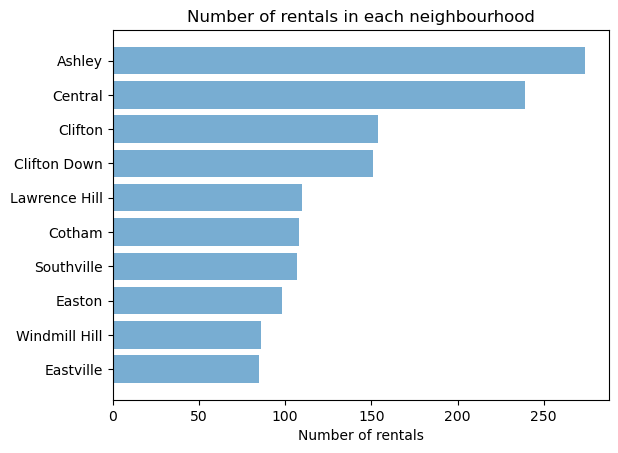

In [5]:
#Restrict analysis to a subset of the neighbourhoods with the most rentals because otherwise things will get 
#too cluttered.

num_neighbourhoods=10 #define how many neighbourhoods to use.

#Now count how many rentals are in each neighbourhood 
neighs=listings_df['neighbourhood_cleansed'].value_counts().index[0:num_neighbourhoods]
totals=listings_df['neighbourhood_cleansed'].value_counts().values[0:num_neighbourhoods]

# Visualise the data (further modelling not required here)
plt.barh(np.flipud(neighs), np.flipud(totals), alpha=0.6); #flip the data to plot descending values
plt.title('Number of rentals in each neighbourhood');
plt.xlabel('Number of rentals')

The areas of Ashley and Central seem to have the most rentals. However, this doesnt take account of the fact 
that some hosts have multiple listings. Let's try counting them up using the 'calculated_host_listings_count' columns - which reflects the number of listings the user has. This column has no missing values, so we can proceed.

We make the assumption that each host's listings are all in the same neighbourhood reported by the 'neighbourhood cleansed' column

In [6]:
num_multi_listings=np.sum((listings_df.calculated_host_listings_count)>1)

print(f"The number of hosts with multiple listings is {num_multi_listings} out of {listings_df.shape[0]}")


The number of hosts with multiple listings is 1167 out of 2260


Roughly half the hosts have multiple listings. Let's try to count again:

Text(0.5, 1.0, 'Number of rentals by neighbourhood (adjusted)')

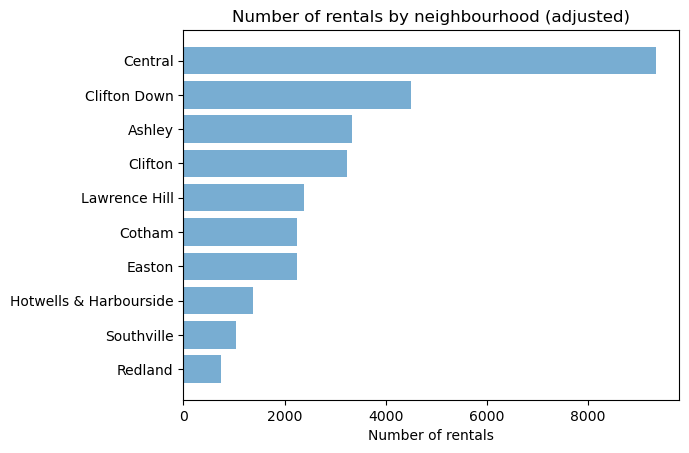

In [7]:
#Count by creating a repeated list:
true_neighbourhood_list=np.repeat(listings_df['neighbourhood_cleansed'], listings_df['calculated_host_listings_count'])
neighs, counts=np.unique(true_neighbourhood_list, return_counts=True)

#Put the counts and labels into a new dataframe
df=pd.DataFrame()
df['neigh']=neighs
df['count']=counts

#Create a list of neighbourhoods sorted by descending value of review score - this is for plotting
neighbourhood_sorted=df.sort_values(by='count', ascending=False)

#Now plot
plt.barh(np.flipud(neighbourhood_sorted['neigh'][0:num_neighbourhoods]), np.flipud(neighbourhood_sorted['count'][0:num_neighbourhoods]), alpha=0.6);
plt.xlabel('Number of rentals')
plt.title('Number of rentals by neighbourhood (adjusted)')

We can see that in fact the 'Central' region has by far the most individual rentals, followed by Clifton Down.

Do visitors prefer staying in one region over another? Let's look to see whether there is actually any difference between the location ratings for the top areas. Start by cleaning the relevant data.

In [8]:
#First let's check whether there are missing values in the location ratings column 

listings_df['review_scores_location'].isnull().sum()/listings_df.shape[0]


0.12964601769911505

Around 12% of values are missing. That's not too bad, there are still around 2000 ratings to use. Let's discard the rows with a 'nan' for location rating, and then look at the differences between ratings in each area.

In [9]:
#Create a new dataframe, dropping the rows with null entries for the location review, and only including
#our top subset of neighbourhoods and the two columns of interest (review scores and neighbourhoods)

location_df=listings_df.dropna(subset=['review_scores_location'])
location_df=location_df[['review_scores_location', 'neighbourhood_cleansed']]

top_neighbourhoods=np.flipud(neighbourhood_sorted['neigh'][0:num_neighbourhoods]).tolist()
location_df=location_df[location_df['neighbourhood_cleansed'].isin(top_neighbourhoods)]

mean_scores=location_df.groupby('neighbourhood_cleansed').mean().review_scores_location.sort_values(ascending=False)
print(f"Mean neighbourhood review scores: {mean_scores} \n ")    ;


Mean neighbourhood review scores: neighbourhood_cleansed
Clifton Down              4.899191
Clifton                   4.894789
Cotham                    4.866800
Redland                   4.852222
Southville                4.845833
Hotwells & Harbourside    4.843182
Central                   4.834161
Ashley                    4.760315
Easton                    4.602614
Lawrence Hill             4.481414
Name: review_scores_location, dtype: float64 
 


Let's pull out the review scores of interest and plot some statistical measures. We will test for normality
to see if we can use a one-way ANOVA to check for meaningful differences between the sets.

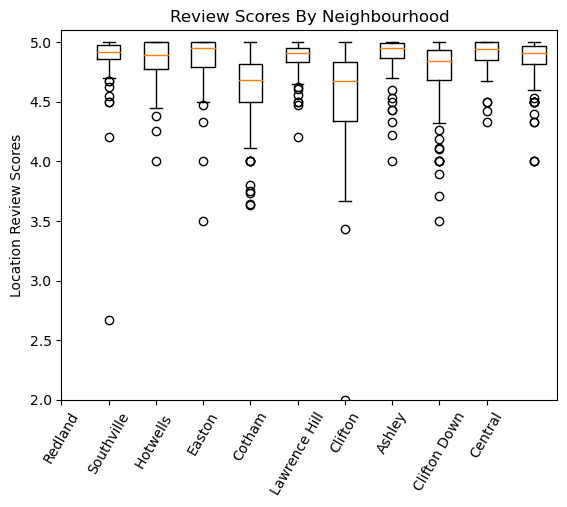

In [12]:
normal_p_scores={}
location_scores={}

for location in top_neighbourhoods:
    location_scores[location]=location_df['review_scores_location'][location_df['neighbourhood_cleansed']==location]
    normal_p_scores[location]=normaltest(location_scores[location])[1]

# Plot mean and inter-quartile range using a boxplot
all_scores=[location_scores[top_neighbourhoods[n]] for n in np.arange(num_neighbourhoods)]
plt.boxplot(all_scores)
plt.ylim([2,5.1])

# Long name labels don't plot well, so let's just abbreviate the ones with an '&' in them
shorten_name=lambda n: n.split('&')[0]
top_10_short=[shorten_name(name) for name in top_neighbourhoods]

plt.xticks(list(np.arange(0,num_neighbourhoods,1)),top_10_short);
plt.xticks(rotation=60)
plt.ylabel('Location Review Scores');
plt.title('Review Scores By Neighbourhood');

Yuck - it's very difficult to see what's going on here. Let's plot again, but using a simple bar chart and defining a new measure with reference to the mean score for all rentals in all locations. That way we can see which ones are below/above average

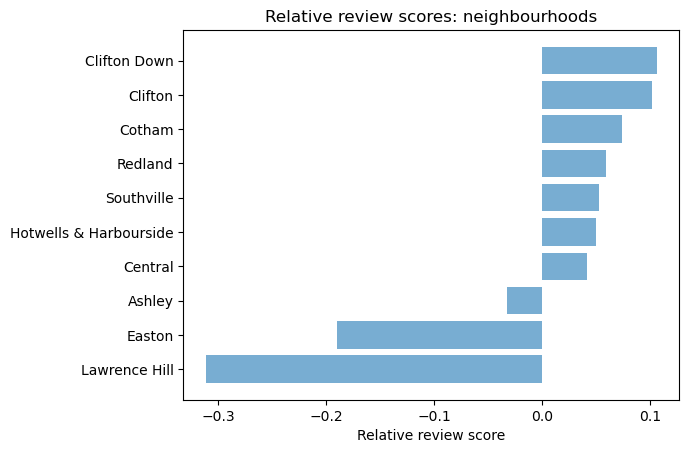

In [13]:
#Start again - create new df with review scores relative to the mean 
loc_df_zeroed=location_df.copy()
loc_df_zeroed['review_scores_location']=loc_df_zeroed['review_scores_location']-loc_df_zeroed['review_scores_location'].mean()
av_scores=loc_df_zeroed.groupby('neighbourhood_cleansed').mean().sort_values(by='review_scores_location')

plt.barh(av_scores.index,av_scores['review_scores_location'], alpha=0.6);
plt.title('Relative review scores: neighbourhoods');
plt.xlabel('Relative review score');

These all look pretty similar - but it seems that Easton and Lawrence Hill  are significantly lower than the rest. Is there any statistical difference between the groups?

In [14]:
#Check that the sets of review scores are normally distributed
if np.sum([p_vals<0.05 for p_vals in normal_p_scores.values()])==num_neighbourhoods:
    print('Scores are all normally distributed')

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=location_df['review_scores_location'], groups=location_df['neighbourhood_cleansed'], alpha=0.05)
comparisons=m_comp.summary()

Scores are all normally distributed


In [15]:
#Look at the results from the pairwise comparison
stats_df = pd.DataFrame.from_records(comparisons.data)

#Pull out the pairs in which the two datasets are statistically different
stats_df[stats_df[6]==True]

,0,1,2,3,4,5,6
2,Ashley,Clifton,0.1345,0.0012,0.0331,0.2359,True
3,Ashley,Clifton Down,0.1389,0.0008,0.036,0.2417,True
5,Ashley,Easton,-0.1577,0.0013,-0.2774,-0.038,True
7,Ashley,Lawrence Hill,-0.2789,0.0,-0.3936,-0.1642,True
13,Central,Easton,-0.2315,0.0,-0.3599,-0.1032,True
15,Central,Lawrence Hill,-0.3527,0.0,-0.4764,-0.2291,True
20,Clifton,Easton,-0.2922,0.0,-0.4235,-0.1609,True
22,Clifton,Lawrence Hill,-0.4134,0.0,-0.5401,-0.2866,True
26,Clifton Down,Easton,-0.2966,0.0,-0.429,-0.1642,True
28,Clifton Down,Lawrence Hill,-0.4178,0.0,-0.5457,-0.2899,True


Now let's have a look at the price of rentals in different areas using the 'price' field

In [24]:
#Are there any missing values in this field?
listings_df.price.isna().sum()


0

There are no missing values, but price is in string format. Let's pull out price information and convert it to a float.

In [25]:
# Remove the string parts of the price field and convert to floats:
price_num=listings_df['price'].apply(lambda x: x.replace('$', '')).apply(lambda x: x.replace(',', ''))
listings_df['price_num']=price_num.astype(float)
listings_df['price_num'][0:4]

0    41.0
1    96.0
2    32.0
3    38.0
Name: price_num, dtype: float64

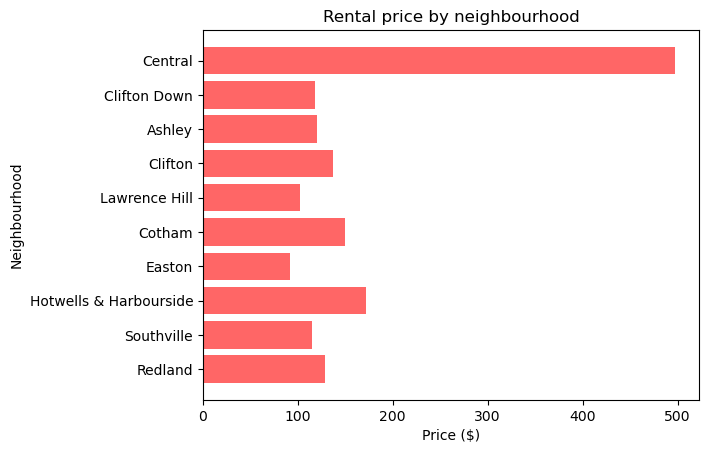

In [26]:
price_by_area=listings_df.groupby('neighbourhood_cleansed').mean().price_num
price_by_area=price_by_area.loc[top_neighbourhoods]
#now plot a bar chart showing type of listings in each neighbourhood

r = np.arange(num_neighbourhoods)
width = 0.25
  
plt.barh(price_by_area.index, price_by_area ,color = 'r', edgecolor = 'none', alpha=0.6)
        

plt.ylabel("Neighbourhood");
plt.xlabel('Price ($)')
plt.title('Rental price by neighbourhood');

The Central area is suspiciously more expensive than other top areas. What's going on? Is the type of rental typically different in this area? Or is the price distorted by a few outliers?

In [27]:
#Look at rental types by area
types_by_area=listings_df.groupby('neighbourhood_cleansed').sum()[['calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']]
types_by_area=types_by_area.loc[top_neighbourhoods]

In [28]:
#The shared room field is full of zeros:
np.sum(types_by_area>0)

#Just plot the other two fields

calculated_host_listings_count_entire_homes     10
calculated_host_listings_count_private_rooms    10
calculated_host_listings_count_shared_rooms      0
dtype: int64

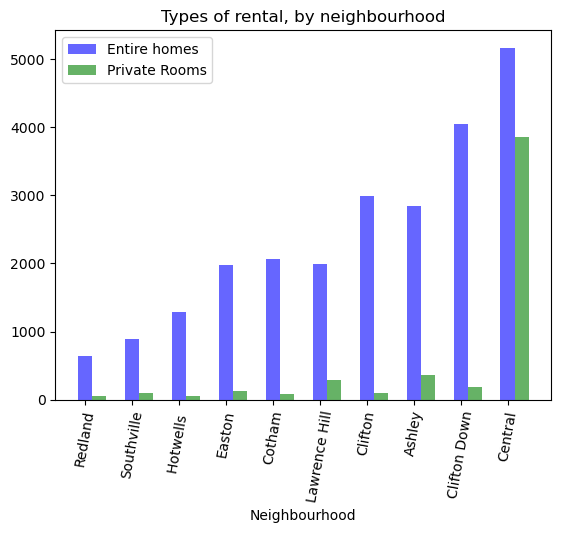

In [29]:
#now plot a bar chart showing type of listings in each neighbourhood
r = np.arange(num_neighbourhoods)
width = 0.3
  
plt.bar(r, types_by_area['calculated_host_listings_count_entire_homes'], color = 'b',
        width = width, alpha=0.6)
        
plt.bar(r + width, types_by_area['calculated_host_listings_count_private_rooms'], color = 'g',
      width = width, alpha=0.6)
          
plt.xlabel("Neighbourhood");
plt.xticks(list(np.arange(0,num_neighbourhoods,1)),top_10_short);
plt.xticks(rotation=80);
plt.legend(['Entire homes', 'Private Rooms', 'Shared Rooms']);
plt.title('Types of rental, by neighbourhood');

In [30]:
#Look at the distribution of prices in each of our top neighbourhoods
price_all=listings_df.groupby('neighbourhood_cleansed').price_num
price_all.describe().loc[top_neighbourhoods]

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Redland,81.0,128.358025,93.156898,31.0,70.00,100.0,148.00,521.0
Southville,107.0,114.542056,119.945765,30.0,64.00,85.0,130.50,1171.0
Hotwells & Harbourside,70.0,171.842857,178.122872,48.0,94.00,115.5,156.50,1050.0
Easton,98.0,91.326531,70.675354,20.0,45.00,81.0,100.00,380.0
Cotham,108.0,150.101852,165.492521,28.0,73.75,100.0,162.50,1274.0
Lawrence Hill,110.0,101.900000,88.238412,25.0,47.00,82.5,120.00,493.0
Clifton,154.0,137.129870,88.988852,29.0,84.25,119.0,169.75,638.0
Ashley,274.0,120.178832,148.964143,25.0,60.25,91.0,128.50,1961.0
Clifton Down,151.0,117.682119,85.576739,33.0,73.00,99.0,133.50,721.0


In [31]:
price_all.median().loc[top_neighbourhoods]

neighbourhood_cleansed
Redland                   100.0
Southville                 85.0
Hotwells & Harbourside    115.5
Easton                     81.0
Cotham                    100.0
Lawrence Hill              82.5
Clifton                   119.0
Ashley                     91.0
Clifton Down               99.0
Central                   130.0
Name: price_num, dtype: float64

In [32]:
listings_df[listings_df.price_num>1000].neighbourhood_cleansed.value_counts().sort_values(ascending=False)


Central                     61
Hotwells & Harbourside       2
Stoke Bishop                 2
Ashley                       1
Bishopston & Ashley Down     1
Windmill Hill                1
Southville                   1
Cotham                       1
Horfield                     1
Name: neighbourhood_cleansed, dtype: int64

The median price for Central is actually very similar to the other region. Prices in Central are distorted by a large number of very expensive properties over $1000 per night. Central also has more entire homes listed than any of our other regions.